# Sea ice diagnostics

The most epic sea-ice diagnostics ever!

In [109]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean 

In [17]:
from dask.distributed import Client, LocalCluster, wait
cluster = LocalCluster(n_workers=8, threads_per_worker=2, memory_limit='16GB',
                       silence_logs=50)
client = Client(address=cluster)
client

/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/distributed/node.py:164: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42055 instead
  expected, actual


Client Scheduler: tcp://127.0.0.1:44909 Dashboard: http://127.0.0.1:42055/status,Cluster Workers: 8 Cores: 16 Memory: 119.21 GiB


In [18]:
import foci_functions

## Read LIM2 output

In [19]:
exp_list = ['FOCI_GJK029']
time_list = [slice('2050-01-01','2550-01-01')]

In [20]:
ds_lim_1m = foci_functions.read_nemo(exp_list, time_list, grid='icemod', freq='1m')

/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK029/outdata/nemo/FOCI_GJK029*1m*icemod.nc


In [89]:
ds_lim_1m_mean = []
for ds in ds_lim_1m:
    
    # Compute monthly climatology
    ds_lim_1m_mean.append( ds.groupby('time.month').mean('time').compute() )

## Read obs from HadISST

In [229]:
sic_had_mean = xr.open_dataset('data/hadisst_ice_ymonmean.nc')['sic'].groupby('time.month').mean('time')
had_area = xr.open_dataset('data/hadisst_area.nc')['cell_area']

In [231]:
sia_had_mean_nh = (sic_had_mean.where(sic_had_mean['latitude'] > 0) * had_area).sum(('longitude','latitude')) * 1e-12
sia_had_mean_sh = (sic_had_mean.where(sic_had_mean['latitude'] < 0) * had_area).sum(('longitude','latitude')) * 1e-12

## Read GIOMAS data

GIOMAS is a model where observed sea-ice concentration is assimilated. 

In [84]:
sit_giomas_mean = xr.open_dataset('data/heff_1979-2022_ymonmean.nc')['heff'].groupby('time.month').mean('time')
area = xr.open_dataset('data/giomas_area.nc')['area'] # this is in km2

In [85]:
# volume in km3
siv_giomas_mean_nh = (sit_giomas_mean.where(sit_giomas_mean['lat'] > 0) * area).sum(('i','j')) * 1e-3
siv_giomas_mean_sh = (sit_giomas_mean.where(sit_giomas_mean['lat'] < 0) * area).sum(('i','j')) * 1e-3 

## Compute Arctic and Antarctic SIA

In [23]:
ds_sia_lim = foci_functions.seaice_areas(ds_lim_1m[0], ds_lim_1m[0]['tarea'], ds_lim_1m[0]['tmask'][0,:,:]).compute()

In [47]:
from importlib import reload
foci_functions = reload(foci_functions)

In [48]:
ds_siv_lim = foci_functions.ice_volumes(ds_lim_1m[0], ds_lim_1m[0]['tarea'], ds_lim_1m[0]['tmask'][0,:,:]).compute()


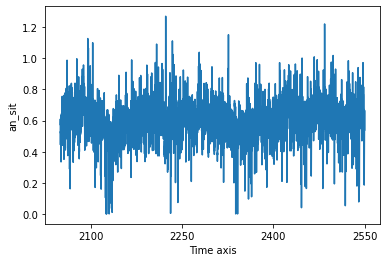

In [51]:
ds_siv_lim['an_sit'].plot()

## Plot Arctic and Antarctic SIA, SIV

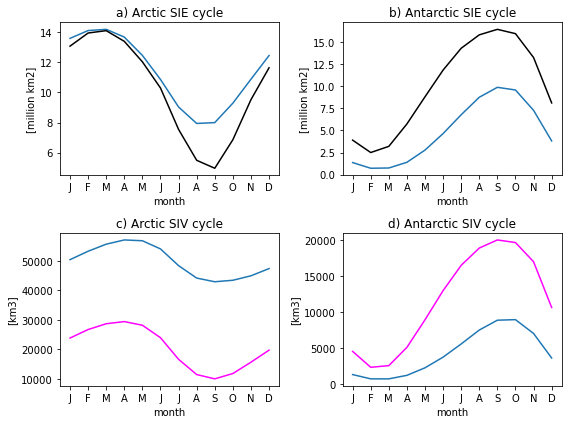

In [232]:
fig1, axs1 = plt.subplots(2,2, figsize=(8,6))
ax1 = axs1.flat

if 1:
    
    name = 'piControl'
    
    # Arctic SIA from LIM
    ds_sia_lim['ar_sia'].sel(time=slice('2050-01-01','2550-01-01')).groupby('time.month').mean('time').plot(ax=ax1[0], 
                                                                                                            label=name)
    sia_had_mean_nh.plot(ax=ax1[0], label='HadISST', color='k')
    
    # Antarctic SIA from LIM
    ds_sia_lim['an_sia'].sel(time=slice('2050-01-01','2550-01-01')).groupby('time.month').mean('time').plot(ax=ax1[1], 
                                                                                                            label=name)
    sia_had_mean_sh.plot(ax=ax1[1], label='HadISST', color='k')
    
    # Arctic SIV from LIM
    ds_siv_lim['ar_siv'].sel(time=slice('2050-01-01','2550-01-01')).groupby('time.month').mean('time').plot(ax=ax1[2], 
                                                                                                            label=name)
    siv_giomas_mean_nh.plot(ax=ax1[2], label='GIOMAS', color='magenta')
    
    # Antarctic SIV from LIM
    ds_siv_lim['an_siv'].sel(time=slice('2050-01-01','2550-01-01')).groupby('time.month').mean('time').plot(ax=ax1[3], 
                                                                                                            label=name)
    siv_giomas_mean_sh.plot(ax=ax1[3], label='GIOMAS', color='magenta')
    
ax1[0].set_title('a) Arctic SIE cycle')
#ax1[0].legend()
ax1[1].set_title('b) Antarctic SIE cycle')
ax1[2].set_title('c) Arctic SIV cycle')
ax1[3].set_title('d) Antarctic SIV cycle')

for ax in ax1[0:2]:
    ax.set_ylabel('[million km2]')
    
for ax in ax1[2:4]:
    ax.set_ylabel('[km3]')

for ax in ax1:
    ax.set_xticks(np.arange(1,13))
    ax.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
    
fig1.tight_layout()
fig1.savefig('plots/sia_siv_climatology.pdf',format='pdf')

## Plot winter/summer means on map

In [209]:
from scipy.interpolate import griddata

def nemo_to_ll(x,y,z):
    
    # put lon lat points in one array of size (size, 2)
    points = np.vstack((x,y)).T
    
    # new grid (regular 0.5x0.5 deg)
    dlon, dlat = 0.5, 0.5
    gx = np.arange(-180,180-dlon,dlon)
    gy = np.arange(-90,90 + dlat,dlat)
    # put new lon,lat in meshgrid
    grid_x, grid_y = np.meshgrid(gx,gy)
    
    # remap
    grid_z = griddata(points, z, (grid_x, grid_y), method='nearest')
    
    return gx, gy, grid_z

## Plot sea ice concentration

Text(0.5, 1.0, 'Antarctic SIC, September')

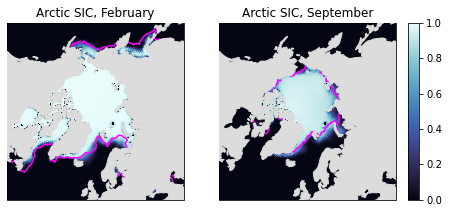

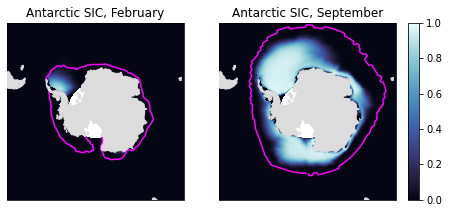

In [210]:
fig1, ax1 = plt.subplots(1, 2, figsize=(8,4), subplot_kw={'projection':ccrs.NorthPolarStereo()})
fig1.subplots_adjust(right=0.8)

fig2, ax2 = plt.subplots(1, 2, figsize=(8,4), subplot_kw={'projection':ccrs.SouthPolarStereo()})
fig2.subplots_adjust(right=0.8)

cmap = cmocean.cm.ice

if 1:
    
    ## =================== Feburary SIC ==========================
    
    # Arctic
    x = ds_lim_1m_mean[0]['nav_lon'].data.flatten()
    y = ds_lim_1m_mean[0]['nav_lat'].data.flatten()
    z = ds_lim_1m_mean[0]['ileadfra'].sel(month=2).data.flatten()
    
    # remap to regular grid
    xx, yy, zz = nemo_to_ll(x,y,z)
    
    # plot LIM
    cf = ax1[0].pcolormesh(xx, yy, zz, cmap=cmap, 
                           vmin=0, vmax=1, 
                           transform=ccrs.PlateCarree()) 
    
    # plot HadISST
    sic_had_mean.sel(month=2).plot.contour(ax=ax1[0], 
                                           levels=[0.15], 
                                           colors='magenta',
                                           transform=ccrs.PlateCarree())
    
    # Antarctic 
    # Select Southern Hemisphere
    _tmp = ds_lim_1m_mean[0]['ileadfra'].sel(month=2).sel(y=slice(0,250))
    _tmp2 = _tmp.sortby(_tmp['nav_lon'][-2,:])
    cf = ax2[0].pcolormesh(_tmp2['nav_lon'][-1,:], _tmp2['nav_lat'][:,0], _tmp2.data, 
                           cmap=cmap, 
                           vmin=0, vmax=1, 
                           transform=ccrs.PlateCarree()) 
    
    # plot HadISST
    sic_had_mean.sel(month=2).plot.contour(ax=ax2[0], 
                                           levels=[0.15], 
                                           colors='magenta',
                                           transform=ccrs.PlateCarree())
    
    
    ### ================================== September ========================== 
    
    #Arctic SIC
    x2 = ds_lim_1m_mean[0]['nav_lon'].data.flatten()
    y2 = ds_lim_1m_mean[0]['nav_lat'].data.flatten()
    z2 = ds_lim_1m_mean[0]['ileadfra'].sel(month=9).data.flatten()
    
    # remap to regular grid
    xx2, yy2, zz2 = nemo_to_ll(x2,y2,z2)
    
    # plot LIM
    cf = ax1[1].pcolormesh(xx2, yy2, zz2, cmap=cmap, 
                           vmin=0, vmax=1, 
                           transform=ccrs.PlateCarree()) 
    
    # plot HadISST
    sic_had_mean.sel(month=9).plot.contour(ax=ax1[1], 
                                           levels=[0.15], 
                                           colors='magenta',
                                           transform=ccrs.PlateCarree())
    
    # Antarctic
    _tmp = ds_lim_1m_mean[0]['ileadfra'].sel(month=9).sel(y=slice(0,250))
    _tmp2 = _tmp.sortby(_tmp['nav_lon'][-2,:])
    cf = ax2[1].pcolormesh(_tmp2['nav_lon'][-1,:], _tmp2['nav_lat'][:,0], _tmp2.data, 
                           cmap=cmap, 
                           vmin=0, vmax=1, 
                           transform=ccrs.PlateCarree()) 
    
    # plot HadISST
    sic_had_mean.sel(month=9).plot.contour(ax=ax2[1], 
                                           levels=[0.15], 
                                           colors='magenta',
                                           transform=ccrs.PlateCarree())
    

# put a colourbar
# (yes, we use a u in colourbar. We are not Americans...)
# Get the positions for plot so we can use same y position and height
for fig, ax in zip([fig1,fig2],[ax1, ax2]):
    
    x_a, y_a, dx_a, dy_a = ax[0].get_position().bounds
    cax1 = fig.add_axes([0.82, y_a, 0.02, dy_a])
    cb1 = plt.colorbar(cf, cax=cax1)
    cb1.set_ticks(np.arange(0,1.2,0.2))

for ax in ax1:
    ax.add_feature(cfeature.LAND, color='Gainsboro', zorder=100)
    ax.set_extent([-180,180,50,90],ccrs.PlateCarree())

for ax in ax2:
    ax.add_feature(cfeature.LAND, color='Gainsboro', zorder=100)
    ax.set_extent([-180,180,-90,-50],ccrs.PlateCarree())

ax1[0].set_title('Arctic SIC, February')
ax1[1].set_title('Arctic SIC, September')

ax2[0].set_title('Antarctic SIC, February')
ax2[1].set_title('Antarctic SIC, September')
    

## Plot sea-ice thickness

/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/ipykernel_launcher.py:147: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/ipykernel_launcher.py:147: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


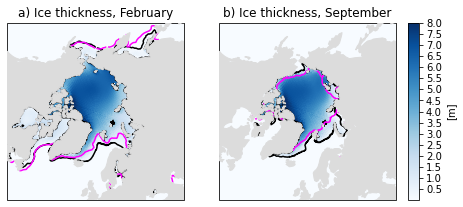

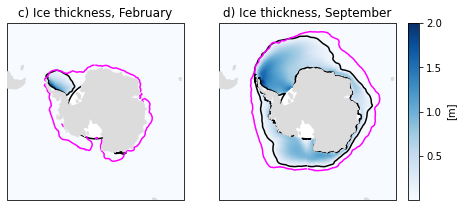

In [233]:
fig1, ax1 = plt.subplots(1, 2, figsize=(8,4), subplot_kw={'projection':ccrs.NorthPolarStereo()})
fig1.subplots_adjust(right=0.8)

fig2, ax2 = plt.subplots(1, 2, figsize=(8,4), subplot_kw={'projection':ccrs.SouthPolarStereo()})
fig2.subplots_adjust(right=0.8)

cmap = plt.cm.Blues #cmocean.cm.ice_r
vmin = 0.01
vmax1 = 8
vmax2 = 2

if 1:
    
    ## =================== Feburary thickness ==========================
    
    # Arctic
    x = ds_lim_1m_mean[0]['nav_lon'].data.flatten()
    y = ds_lim_1m_mean[0]['nav_lat'].data.flatten()
    z1 = ds_lim_1m_mean[0]['ileadfra'].sel(month=2).data.flatten()
    z2 = ds_lim_1m_mean[0]['iicethic'].sel(month=2).data.flatten()
    
    # remap conc and thickness to regular grid
    xx, yy, zz1 = nemo_to_ll(x,y,z1)
    xx, yy, zz2 = nemo_to_ll(x,y,z2)
    
    # plot LIM thickness
    cf1 = ax1[0].pcolormesh(xx, yy, zz2, cmap=cmap, 
                            vmin=vmin, vmax=vmax1, 
                            transform=ccrs.PlateCarree(),
                            rasterized=True) 
    
    ct = ax1[0].contour(xx, yy, zz1, 
                        colors='k',
                        levels=[0.15],
                        transform=ccrs.PlateCarree()) 
    
    # plot HadISST
    sic_had_mean.sel(month=2).plot.contour(ax=ax1[0], 
                                           levels=[0.15], 
                                           colors='magenta',
                                           transform=ccrs.PlateCarree())
    
    # Antarctic 
    # Select Southern Hemisphere
    _tmp1 = ds_lim_1m_mean[0]['ileadfra'].sel(month=2).sel(y=slice(0,250))
    _tmp2 = ds_lim_1m_mean[0]['iicethic'].sel(month=2).sel(y=slice(0,250))
    # NEMO grid starts and ends at 73.5E. Sort from -180 to 180
    _tmp1_c = _tmp1.sortby(_tmp1['nav_lon'][-2,:])
    _tmp2_c = _tmp2.sortby(_tmp2['nav_lon'][-2,:])
    # Plot thickness
    cf2 = ax2[0].pcolormesh(_tmp2_c['nav_lon'][-1,:], _tmp2_c['nav_lat'][:,0], _tmp2_c.data, 
                            cmap=cmap, 
                            vmin=vmin, vmax=vmax2, 
                            transform=ccrs.PlateCarree(),
                            rasterized=True) 
    # Concentration
    ct = ax2[0].contour(_tmp1_c['nav_lon'][-1,:], _tmp1_c['nav_lat'][:,0], _tmp1_c.data, 
                        colors='k',
                        levels=[0.15],
                        transform=ccrs.PlateCarree()) 
    
    # plot HadISST
    sic_had_mean.sel(month=2).plot.contour(ax=ax2[0], 
                                           levels=[0.15], 
                                           colors='magenta',
                                           transform=ccrs.PlateCarree())
    
    
    ### ================================== September ========================== 
    
    #Arctic SIC
    x = ds_lim_1m_mean[0]['nav_lon'].data.flatten()
    y = ds_lim_1m_mean[0]['nav_lat'].data.flatten()
    z1 = ds_lim_1m_mean[0]['ileadfra'].sel(month=9).data.flatten()
    z2 = ds_lim_1m_mean[0]['iicethic'].sel(month=9).data.flatten()
    
    # remap to regular grid
    xx, yy, zz1 = nemo_to_ll(x,y,z1)
    xx, yy, zz2 = nemo_to_ll(x,y,z2)
    
    # plot LIM
    cf1 = ax1[1].pcolormesh(xx, yy, zz2, cmap=cmap, 
                            vmin=vmin, vmax=vmax1, 
                            transform=ccrs.PlateCarree(),
                            rasterized=True) 
    
    ct = ax1[1].contour(xx, yy, zz1, 
                        colors='k',
                        levels=[0.15],
                        transform=ccrs.PlateCarree()) 
    
    # plot HadISST
    sic_had_mean.sel(month=9).plot.contour(ax=ax1[1], 
                                           levels=[0.15], 
                                           colors='magenta',
                                           transform=ccrs.PlateCarree())
    
    # Antarctic
    _tmp1 = ds_lim_1m_mean[0]['ileadfra'].sel(month=9).sel(y=slice(0,250))
    _tmp2 = ds_lim_1m_mean[0]['iicethic'].sel(month=9).sel(y=slice(0,250))
    _tmp1_c = _tmp1.sortby(_tmp1['nav_lon'][-2,:])
    _tmp2_c = _tmp2.sortby(_tmp2['nav_lon'][-2,:])
    cf2 = ax2[1].pcolormesh(_tmp2_c['nav_lon'][-1,:], _tmp2_c['nav_lat'][:,0], _tmp2_c.data, 
                            cmap=cmap, 
                            vmin=vmin, vmax=vmax2, 
                            transform=ccrs.PlateCarree(),
                            rasterized=True) 
    
    ct = ax2[1].contour(_tmp1_c['nav_lon'][-1,:], _tmp1_c['nav_lat'][:,0], _tmp1_c.data, 
                        colors='k', 
                        levels=[0.15], 
                        transform=ccrs.PlateCarree()) 
    
    # plot HadISST
    sic_had_mean.sel(month=9).plot.contour(ax=ax2[1], 
                                           levels=[0.15], 
                                           colors='magenta',
                                           transform=ccrs.PlateCarree())
    

# put a colourbar
# (yes, we use a u in colourbar. We are not Americans...)
# Get the positions for plot so we can use same y position and height
for fig, ax, vm, cf in zip([fig1,fig2],[ax1, ax2],[vmax1,vmax2],[cf1,cf2]):
    
    x_a, y_a, dx_a, dy_a = ax[0].get_position().bounds
    cax1 = fig.add_axes([0.82, y_a, 0.02, dy_a])
    cb1 = plt.colorbar(cf, cax=cax1)
    cb1.set_ticks(np.arange(0,vm+0.5,0.5))
    cb1.set_label('[m]')

for ax in ax1:
    ax.add_feature(cfeature.LAND, color='Gainsboro', zorder=100)
    ax.set_extent([-180,180,50,90],ccrs.PlateCarree())

for ax in ax2:
    ax.add_feature(cfeature.LAND, color='Gainsboro', zorder=100)
    ax.set_extent([-180,180,-90,-50],ccrs.PlateCarree())

ax1[0].set_title('a) Ice thickness, February')
ax1[1].set_title('b) Ice thickness, September')

ax2[0].set_title('c) Ice thickness, February')
ax2[1].set_title('d) Ice thickness, September')

for fig in [fig1,fig2]:
    fig.tight_layout()
    
fig1.savefig('plots/arctic_ice_thickness.pdf',format='pdf')
fig2.savefig('plots/antarctic_ice_thickness.pdf',format='pdf')

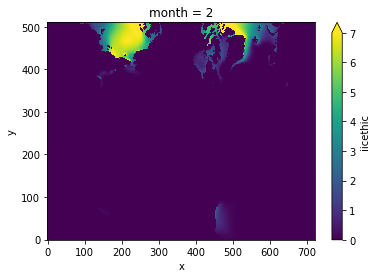

In [200]:
ice = ds_lim_1m_mean[0]['iicethic'].sel(month=2)
ice.plot(vmin=0,vmax=7)

In [207]:
def nemo_to_ll(x,y,z):
    
    # put lon lat points in one array of size (size, 2)
    points = np.vstack((x,y)).T
    
    # new grid (regular 0.5x0.5 deg)
    dlon, dlat = 0.5, 0.5
    gx = np.arange(-180,180-dlon,dlon)
    gy = np.arange(-90,90 + dlat,dlat)
    
    # put new lon,lat in meshgrid
    grid_x, grid_y = np.meshgrid(gx,gy)
    
    # remap
    grid_z = griddata(points, z, (grid_x, grid_y), method='nearest')
    
    return gx, gy, grid_z

xx2, yy2, zz1 = nemo_to_ll(ice['nav_lon'].data.flatten(),
                           ice['nav_lat'].data.flatten(),
                           ice.data.flatten())

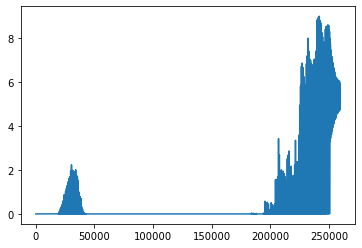

In [208]:
plt.plot(zz1.flatten())
#plt.plot(ice.data.flatten())